In [1]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import glob
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
#sys.path.append("/Users/kmarvel/Google Drive/python-utils")
sys.path.append("../python-utils")
import CMIP5_tools as cmip5
import DA_tools
import Plotting

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

import requests
import pandas as pd
import importlib

### Set classic Netcdf (ver 3)
cdms.setNetcdfShuffleFlag(0)
cdms.setNetcdfDeflateFlag(0)
cdms.setNetcdfDeflateLevelFlag(0)

#external_drive='/Volumes/CMIP6/'
external_drive="/home/kdm2144/"

In [2]:
#Region locations
NCA4regions={}
#Northwest (NW): (125°W–111°W, 42°N–49°N)
NCA4regions["NW"]=cdutil.region.domain(longitude=(-125,-111),latitude=(42,49))
#Southwest (SW): (124°W–102°W, 31°N–42°N)
NCA4regions["SW"]=cdutil.region.domain(longitude=(-124,-102),latitude=(31,42))
#Upper Great Plains (GPu): (116°W–95°W, 40°N–49°N)
NCA4regions["GPu"]=cdutil.region.domain(longitude=(-116,-95),latitude=(40,49))
#Lower Great Plains (GPl): (107°W–93°W, 26°N–40°N)
NCA4regions["GPl"]=cdutil.region.domain(longitude=(-107,-93),latitude=(26,40))
#Midwest (MW): (97°W–80°W, 36°N–50°N)
NCA4regions["MW"]=cdutil.region.domain(longitude=(-97,-80),latitude=(36,50))
#Northeast (NE): (82°W–67°W, 37°N–48°N)
NCA4regions["NE"]=cdutil.region.domain(longitude=(-82,-67),latitude=(37,48))
#Southeast (SE): (95°W–76°W, 25°N–39°N)
NCA4regions["SE"]=cdutil.region.domain(longitude=(-95,-76),latitude=(25,39))




In [3]:


def get_file(region,variable,scenario,month):
    mfile=None
    snfiles=glob.glob(rootdirec+"DroughtSN/"+region+"/*")
    variables_match=np.unique([x.split(".")[0].split("/")[-1] for x in snfiles])


    if variable in variables_match:

        vfiles=glob.glob(rootdirec+"DroughtSN/"+region+"/*"+variable+".*")
        scenarios_match=np.unique([x.split(".")[1] for x in vfiles])
        if scenario in scenarios_match:
            sfiles=glob.glob(rootdirec+"DroughtSN/"+region+"/*"+variable+".*"+scenario+"*")
            months = np.unique([x.split(".")[3] for x in sfiles])
            if month in months:
                mfile=glob.glob(rootdirec+"DroughtSN/"+region+"/*"+variable+".*"+scenario+"*"+month+"*")[0]

    return mfile
def get_crossing_time(region,variable,scenario,month):
    vcert=stats.norm.interval(.99)[1]
    mfile=get_file(region,variable,scenario,month)
    if mfile is None:
        crossing_time=None
       
    else:
        f=cdms.open(mfile)
        data=f(variable+"_SN")
        avg=MV.average(data,axis=0)
        threshexceed=np.where(np.abs(avg)>vcert)[0]
        #If it never exceeds the threshold, return None
        if len(threshexceed)==0:
            return(None)
        #If it hasn't exceeded the threshold by the last time step, return None
        if len(avg)-1 not in threshexceed:
            return(None)
        if len(np.where(np.diff(threshexceed)>1)[0])>0:
            isnot1=np.max(np.where(np.diff(threshexceed)>1)[0])+1
        else:
            isnot1=0
        staysabove=int(threshexceed[isnot1])
        crossing_time=int(cmip5.get_plottable_time(data)[staysabove])
        f.close()
    return(crossing_time)

def colorscenario(scenario):
    d={}
    d["ssp126"] = "b"
    d["ssp245"] = "g"
    d["ssp370"] = "orange"
    d["ssp585"] = "r"
    return(d[scenario])

def scenario_bar(region,ax=None,backup=False):
    if ax is None:
        fig=plt.figure()
        ax=fig.add_subplot(111)
    if backup:
        droughtdirec="DroughtSNBackup/"
    else:
        droughtdirec="DroughtSN/"
    snfiles=glob.glob(rootdirec+droughtdirec+region+"/*")
    variables_match=np.unique([x.split(".")[0].split("/")[-1] for x in snfiles])

    counter=0
    labels=[]
    for variable in variables_match:
        
        #find the season of max signal
        vfiles=glob.glob(rootdirec+droughtdirec+region+"/*"+variable+".*")
        months = np.unique([x.split(".")[3] for x in vfiles])
        
        if len(months)==1:
            month_maxsig=months[0]
        else:
            cts=[]
            for month in months:
                
                ct=get_crossing_time(region,variable,"ssp585",month)
                if ct is None:
                    ct=2101
                cts+=[ct]
            month_maxsig=months[np.argmin(np.array(cts))]
        labels+=[month_maxsig+" "+variable]
        scencts=[]
        increment=0
        for scenario in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
            ct=get_crossing_time(region,variable,scenario,month_maxsig)
            
            if ct is not None:
                ct=ct
            else:
                ct=2100
            ax.barh(counter+increment,ct,color=colorscenario(scenario),height=.2)
            increment+=.2
            
        counter+=1
    ax.set_xlim(2000,2100)
    ax.set_yticks(np.arange(len(variables_match))+.5)
    ax.set_yticklabels(labels)
    
def plot_SN(region,variable,scenario,month,average_only=False,**kwargs):
   # print(scenario)
    f=cdms.open(get_file(region,variable,scenario,month))
  #  print("file opened")
    data=f(variable+"_SN")
   # print("data loaded")
    if not average_only:
        [Plotting.time_plot(data[i],lw=1,c="k",alpha=.5) for i in range(data.shape[0])]
    avg=MV.average(data,axis=0)
    Plotting.time_plot(avg,c=colorscenario(scenario),lw=5,**kwargs)
    if avg[-1]>0:
        plt.axhline(vcert,c="r")
    else:
        plt.axhline(-1*vcert,c="r")
    f.close()
    
    

def set_up_axis():
    fig3=plt.figure(figsize=(20,8))
    gs = fig3.add_gridspec(2, 12)
    ax1=fig3.add_subplot(gs[0,0:3])
    ax2=fig3.add_subplot(gs[0,3:6])
    ax3=fig3.add_subplot(gs[0,6:9])
    ax4=fig3.add_subplot(gs[0,9:])
    ax5=fig3.add_subplot(gs[1,0:4])
    ax6=fig3.add_subplot(gs[1,4:8])
    ax7=fig3.add_subplot(gs[1,8:])
    d={}
    d["NW"]=ax1
    d["GPu"]=ax2
    d["MW"]=ax3
    d["NE"]=ax4
    d["SW"]=ax5
    d["GPl"]=ax6
    d["SE"]=ax7
    plt.tight_layout()
    return d

def all_regions_SN():
    d=set_up_axis()
    for region in NCA4regions.keys():
        ax=d[region]
        scenario_bar(region,ax)
        ax.set_title(region)
    plt.tight_layout()   
    #plt.savefig("/Users/kmarvel/Google Drive/NOAA_MAPP_DROUGHT/Figures/SN_bars.png")

def plot_all_scenarios_and_uncertainty(region,variable,season,**kwargs):
    scenarios=["ssp126","ssp245","ssp370","ssp585"]
    if "legend" in kwargs.keys():
        legend=kwargs.pop("legend")
    else:
        legend=True
    for i in range(4):
        plt.subplot(2,2,i+1)
        plot_SN(region,variable,scenarios[i],season,**kwargs)
        plt.title(scenarios[i])
    plt.tight_layout()
    
def plot_all_scenarios(region,variable,season,**kwargs):
    if "legend" in kwargs.keys():
        legend=kwargs.pop("legend")
    else:
        legend=True
    scenarios=["ssp126","ssp245","ssp370","ssp585"]
    for i in range(4):
        plot_SN(region,variable,scenarios[i],season,average_only=True,label=scenarios[i],**kwargs)
    if legend:
         plt.legend(loc=0,fontsize=10)

def get_ok_models_variable(variable,region):

    models={}
    #readstem="/Users/kmarvel/Documents/DATA/dester/regional_averages/"
    #readstem = "/Volumes/SahelData/CMIP6Drought/NCA4/"
    #readstem = "/Users/kmarvel/Documents/DATA/dester/regional_averages/NCA4/"
    readstem = "/home/kdm2144/DROUGHT/NCA4/"
    experiments=[x.split("/")[-1] for x in glob.glob(readstem+region+"/"+variable+"/*")]
    for experiment in experiments:
        readdirec=readstem+region+"/"+variable+"/"+experiment+"/"
        rips=[x.split(".")[3] for x in glob.glob(readdirec+"*")]
        models[experiment]=np.unique([x.split(".")[2] for x in glob.glob(readdirec+"*")])
    okmodels=models[experiments[0]]
    for experiment in experiments[1:]: 
        #
        okmodels=np.intersect1d(okmodels,models[experiment])
    return okmodels
# def get_ok_models(region):
#     variables=["tas","mrro","mrros","mrso","mrsos","pr","evspsbl","prsn"]
#     ok=get_ok_models_variable(variables[0],region)
#     for variable in variables[1:]:
#         ok=np.intersect1d(ok,get_ok_models_variable(variable,region))
#     return ok

def get_available_models(variable,experiment,region):
    return np.unique([x.split(".")[-3] for x in glob.glob("/home/kdm2144/DROUGHT/NCA4/"+region+"/"+variable+"/"+experiment+"/*")])

def get_ok_models(region):
    models=[x.split("_fx_")[-1].split(".")[0] for x in glob.glob("/home/kdm2144/DROUGHT/fixedvar/sftlf*")]
    #variables=['tas', 'mrro', 'mrros', 'mrso', 'pr'] #add mrsos, evspsbl and prsn when they download
    variables=["evspsbl"]
    experiments=["piControl","historical","ssp585"] #require at least 1 ens member in each of these experiments
    for variable in variables:
        for experiment in experiments:
            models=np.intersect1d(models,get_available_models(variable,experiment,region))
    return models

def commonElements(arr): 
      
    # initialize result with first array as a set 
    result = set(arr[0]) 
  
    # now iterate through list of arrays starting from 
    # second array and take intersection_update() of  
    # each array with result. Every operation will  
    # update value of result with common values in 
    # result set and intersected set 
    for currSet in arr[1:]: 
        result.intersection_update(currSet) 
  
    return list(result) 

#Get ensemble
#for model in okmodels:
def get_ensemble_dictionary(variable,region,exclude_piC=True):
    #okmodels=get_ok_models(variable,region)
    okmodels=get_ok_models(region)
    EXPS={}
    #readstem = "/Volumes/SahelData/CMIP6Drought/NCA4/"
    readstem = "/home/kdm2144/DROUGHT/NCA4/"
    histfut=[x.split("/")[-1] for x in glob.glob(readstem+region+"/"+variable+"/*")]
    if exclude_piC:
        histfut.remove("piControl")
    for experiment in histfut:
        ENSEMBLE={}

        readdirec=readstem+region+"/"+variable+"/"+experiment+"/"
        for model in okmodels:
            ENSEMBLE[model]=sorted([x.split(".")[3] for x in glob.glob(readdirec+"*"+model+".*")])
        EXPS[experiment]=ENSEMBLE
    
    return EXPS

# def get_common_ensembles(variable,region):
#     OK={}
#     EXPS=get_ensemble_dictionary(variable,region)
#     #readstem = "/Volumes/SahelData/CMIP6Drought/NCA4/"
#     readstem = "/home/kdm2144/DROUGHT/NCA4/"
#     histfut=[x.split("/")[-1] for x in glob.glob(readstem+region+"/"+variable+"/*")]
    
#     histfut.remove("piControl")
    
    
#     for model in get_ok_models(region):
#         OK[model]=sorted(commonElements([EXPS[x][model] for x in histfut]))
#     return OK

# def get_ensemble_filenames(variable,region,experiment):
#     fnames=[]
#     #if experiment != "piControl":
#      #   OK=get_common_ensembles(variable,region)
#    # else:
#     OK=get_ensemble_dictionary(variable,region,exclude_piC=False)
#     #readstem = "/Volumes/SahelData/CMIP6Drought/NCA4/"
#     readstem = "/home/kdm2144/DROUGHT/NCA4/"
#     readdirec=readstem+region+"/"+variable+"/"+experiment+"/"
#     for model in sorted(OK.keys()):
#         for rip in sorted(OK[model]):
#             fname=variable+"."+experiment+"."+model+"."+rip+".nc"
#             fnames+=[readdirec+fname]
#     return fnames
def get_ensemble_filenames(variable,region,experiment):
    fnames=[]
    for model in get_ok_models(region):
        fnames+=glob.glob("/home/kdm2144/DROUGHT/NCA4/"+region+"/"+variable+"/"+experiment+"/"+variable+"."+experiment+"."+model+".*")
    return fnames

def get_color(scenario):
    d={}
    d["ssp585"]="#d62728"
    d["ssp370"]="#ff7f0e"
    d["ssp245"]="#2ca02c"
    d["ssp126"]="#1f77b4"
    d["historical"]="#8c564b"
    d["piControl"]="#9467bd"
    if scenario in d.keys():
        return d[scenario]
    else:
        return "k"
def get_label(scenario):
    d={}
    d["ssp585"]="SSP5-8.5"
    d["ssp370"]="SSP3-7.0"
    d["ssp245"]="SSP2-4.6"
    d["ssp126"]="SSP1-2.6"
    d["historical"]="historical"
    d["piControl"]="piControl"
    if scenario in d.keys():
        return d[scenario]
    else:
        return "--"

def bootstrap_slopes(noise,L):
    nt=noise.shape[0]-L
    test = MV.zeros((nt,L))
    
    for i in range(nt):
        test[i]=noise[i:L+i]
    test.setAxis(1,noise[:L].getAxis(0))
    return cmip5.get_linear_trends(test)


def fast_slopes(noise,L):
#L=30
    ntrends=int(noise.shape[0]/L)
    trunc=noise[:L*ntrends]
    tax=noise[:L].getTime()
    fast=trunc.reshape(ntrends,L)
    fast.setAxis(1,tax)
    return(cmip5.get_linear_trends(fast))

def get_model_colors(model,cmap=cm.Dark2):

    model_names=get_ok_models("SW")
    L=float(len(model_names))
    d={}
    for i in range(int(L)):
        numerator=float(np.mod(i,8))
        d[model_names[i]]=cmap(numerator/8.)
    return d[model]
    
def get_model_ls(model):

    model_names=get_ok_models("SW")
    L=int(len(model_names))
    d={}
    for i in range(int(L)):
        if i in np.arange(0,L/4):
            d[model_names[i]]="solid"
        elif i in np.arange(L/4,L/2):
            d[model_names[i]]="dotted"
        elif i in np.arange(L/2,3*L/4):
            d[model_names[i]]="dashed"
        else:
            d[model_names[i]]="dashdot"
        
        
    return d[model]

class TOE():
    def __init__(self,variable,region,verbose=False):
        self.variable=variable
        self.region=region
        self.verbose=verbose
        self.readstem = "/home/kdm2144/DROUGHT/NCA4/"
    def get_ensemble(self,experiment):
        if not hasattr(self,experiment):
            if experiment != "piControl":
                fnames=get_ensemble_filenames(self.variable,self.region,experiment)
                nfiles=len(fnames)
                i=0
                fil=fnames[i]
                f=cdms.open(fil)
                data=f(self.variable)
                tax=data.getTime()
                if experiment != "piControl":
                    ntime=len(tax)


                else:
                    ntime=250*12
                    tax2=cdms.createAxis(tax[:ntime])
                    for key in tax.attributes.keys():
                        setattr(tax2,key,tax.attributes[key])
                    tax=tax2
                alldata=MV.zeros((nfiles,ntime))+1.e20
                alldata[i]=data[:ntime]
                f.close()
                for i in range(nfiles)[1:]:
                    fil=fnames[i]
                    f=cdms.open(fil)
                    data=f(self.variable)
                    if len(data.getTime())==ntime:
                        alldata[i]=data
                    elif len(data.getTime())>ntime:
                        alldata[i]=data[:ntime]
                    else:
                        badlength=len(data.getTime())
                        alldata[i,:badlength]=data
                    f.close()
                alldata=MV.masked_where(np.abs(alldata)>1.e10,alldata)
                alldata.setAxis(1,tax)    
                modax=cmip5.make_model_axis(fnames)
                alldata.setAxis(0,modax)
                #convert soil moisture to z scores
                # if self.variable in ["mrso","mrsos"]:
                #     alldata=self.standardize_zscore(alldata)
                # else:
                #     alldata=self.convert_to_percentage(alldata)
                setattr(self,experiment,MV.masked_where(np.abs(alldata)>1.e10,alldata))
            else:
                self.piControl=self.concatenate_piControl()

    def convert_to_percentage(self,alldata):

        self.get_ensemble("piControl")
        piC=self.piControl
        cdutil.setTimeBoundsMonthly(piC)
        npiCmodels,npiCt=piC.shape
        ac=cdutil.ANNUALCYCLE.climatology(piC)


        pmodels=[x.split(".")[-3] for x in cmip5.models(piC)]
        if len(cmip5.models(alldata)[0].split("."))==1:
            emodels=cmip5.models(alldata)
        else:
            emodels=[x.split(".")[-3] for x in cmip5.models(alldata)]
        
        nmembers=len(emodels)
        Z=np.zeros_like(alldata)
        for ens_i in range(nmembers):
            model=emodels[ens_i]
            corr_piC=pmodels.index(model)
            ac_piC=ac[corr_piC]

            for month_i in range(12):
                Z[ens_i,month_i::12]=(alldata[ens_i,month_i::12]-ac_piC[month_i])/ac_piC[month_i]
        Z=cmip5.cdms_clone(Z*100.,alldata)
        Z.id=alldata.id
        return(Z)
    def standardize_zscore(self,alldata):

        self.get_ensemble("piControl")
        piC=self.piControl
        cdutil.setTimeBoundsMonthly(piC)
        npiCmodels,npiCt=piC.shape
        mu=np.ma.zeros((npiCmodels,12))
        sigma=np.ma.zeros((npiCmodels,12))
        for i in range(12):
            mu[:,i]=np.ma.average(piC[:,i::12],axis=1)
            sigma[:,i]=np.ma.std(piC[:,i::12],axis=1)


        pmodels=[x.split(".")[-3] for x in cmip5.models(piC)]
        if len(cmip5.models(alldata)[0].split("."))==1:
            emodels=cmip5.models(alldata)
        else:
            emodels=[x.split(".")[-3] for x in cmip5.models(alldata)]
        nmembers=len(emodels)
        Z=np.zeros_like(alldata)
        for ens_i in range(nmembers):
            model=emodels[ens_i]
            corr_piC=pmodels.index(model)
            mu_piC=mu[corr_piC]
            sigma_piC=sigma[corr_piC]
            for month_i in range(12):
                Z[ens_i,month_i::12]=(alldata[ens_i,month_i::12]-mu_piC[month_i])/sigma_piC[month_i]
        Z=cmip5.cdms_clone(Z,alldata)
        Z.id=alldata.id
        return(Z)
    def ensemble_average(self,experiment):
        self.get_ensemble(experiment)
        data=getattr(self,experiment)
        nens,ntime=data.shape
        #models=sorted(self.ensemble_dict.keys())
        models=get_ok_models(self.region)
        
        nmod=len(models)
       # print("Number of models is", nmod)
        EnsembleAverage=np.ma.zeros((nmod,ntime))+1.e20
        fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
        counter=0
        for model in models:
            #fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if len(I)>0:
                EnsembleAverage[counter]=np.ma.average(data.asma()[I],axis=0)
            else:
                if self.verbose:
                    print("missing data for "+model+" "+self.variable+" "+experiment)
            counter+=1
        EnsembleAverage=MV.masked_where(np.abs(EnsembleAverage)>1.e10,EnsembleAverage)
        EnsembleAverage=MV.masked_where(np.isnan(EnsembleAverage),EnsembleAverage)
        EnsembleAverage=MV.array(EnsembleAverage)
        
        EnsembleAverage.setAxis(1,data.getTime())
        modax=cmip5.make_model_axis(models)
        EnsembleAverage.setAxis(0,modax)
        cdutil.setTimeBoundsMonthly(EnsembleAverage)            
        return EnsembleAverage

       

    def single_member_ensemble(self,experiment):
        """Get a single member from each ensemble"""
        self.get_ensemble(experiment)
        data=getattr(self,experiment)
        nens,ntime=data.shape
        #models=sorted(self.ensemble_dict.keys())
        models=get_ok_models(self.region)
        nmod=len(models)
        SingleMember=np.ma.zeros((nmod,ntime))+1.e20
        fnames=sorted(get_ensemble_filenames(self.variable,self.region,experiment))
        counter=0
        for model in models:
            fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if len(I)>0:
                first_member=I[0]
                SingleMember[counter]=data.asma()[first_member]
            else:
                if self.verbose:
                    print("missing data for "+model+" "+self.variable+" "+experiment)
            counter+=1
       
        SingleMember=MV.masked_where(np.abs(SingleMember)>1.e10,SingleMember)
        SingleMember=MV.masked_where(np.isnan(SingleMember),SingleMember)
       # SingleMember=MV.array(SingleMember)
        SingleMember.setAxis(1,data.getTime())
        modax=cmip5.make_model_axis(models)
        SingleMember.setAxis(0,modax)
        cdutil.setTimeBoundsMonthly(SingleMember)  
        return SingleMember
    
    def splice_historical(self,ssp,single_member=False):
        #concatenate hist and future
        if single_member:
            func=self.single_member_ensemble
        else:
            func=self.ensemble_average
        hist=func("historical")
        all_data=MV.concatenate((hist,func(ssp)),axis=1)
        tax=cdms.createAxis(np.arange(all_data.shape[1]))
        tax.units=hist.getTime().units
        tax.id='time'
        tax.designateTime()
        all_data.setAxis(1,tax)
        cdutil.setTimeBoundsMonthly(all_data)
        all_data.setAxis(0,hist.getAxis(0))
        all_data.id=hist.id
        cdutil.setTimeBoundsMonthly(all_data)
        return all_data
        
    def plot_future(self,season,single_member=True,plot_historical=True):
        if single_member:
            func=self.single_member_ensemble
        else:
            func=self.ensemble_average
        hist=func("historical")
        
        start_time=cdtime.comptime(1951,1,1)
        end_time=cdtime.comptime(1980,12,31)
        clim = getattr(cdutil,season).climatology(hist(time= (start_time, end_time, 'co')))
        if plot_historical:
            timedata=getattr(cdutil,season).departures(hist,ref=clim)
            Plotting.time_plot(MV.average(timedata,axis=0),color=get_color("historical"),label=get_label("historical"))
        for ssp in ["ssp126","ssp245","ssp370","ssp585"]:
            rawdata=func(ssp)
            timedata=getattr(cdutil,season).departures(rawdata,ref=clim)
            Plotting.time_plot(MV.average(timedata,axis=0),color=get_color(ssp),label=get_label(ssp))
        plt.legend()
    def signals(self,season,ssp,single_member=False,start_time=None,init=10):
        if start_time is None:
            start_time=cdtime.comptime(1980,1,1)
        end_time=cdtime.comptime(2100,12,31)
        trend_end=start_time.add(init,cdtime.Years)
        if single_member:
            func=self.single_member_ensemble
        else:
            func=self.ensemble_average
        all_data=self.splice_historical(ssp,single_member=single_member)
        hist=func("historical")
        
        

        #define the anomaly base period
        clim_start_time=cdtime.comptime(1951,1,1)
        clim_end_time=cdtime.comptime(1980,12,31)
        clim = getattr(cdutil,season).climatology(hist(time= \
                                                       (clim_start_time, \
                                                        clim_end_time, 'co')))
        #get seasonal anomalies
        seasonal_data=getattr(cdutil,season).departures(all_data,ref=clim)
        #set up array for signals
        nmod,nyears=seasonal_data.shape
        tax=seasonal_data(time=(trend_end,end_time)).getTime()
        nsig=len(tax)
        signals=MV.zeros((nmod,nsig))
        missing_data=all_data[:,-1].mask
        #calculate signals
        counter=0
        while trend_end.cmp(end_time)<0:
            signals[:,counter]=MV.masked_where(missing_data,cmip5.get_linear_trends(seasonal_data(time=(start_time,trend_end))))
            trend_end=trend_end.add(1,cdtime.Years)
            counter+=1
        signals.setAxis(0,hist.getAxis(0))
        signals.setAxis(1,tax)
        return signals

    def concatenate_piControl(self,season=None,compressed=True,min_years=200):
        experiment="piControl"
        fnames=sorted(get_ensemble_filenames(self.variable,self.region,experiment))
        #models=sorted(self.ensemble_dict.keys())
        models=get_ok_models(self.region)
        
        nmod=len(models)
        ntimes=[]
        model_names=[]
        good_models=[]
        #Loop over without loading data to figure out the shortest length control run
        for model in models:
           # print(model)
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if len(I)>0:
                if ((model == 'IPSL-CM6A-LR' ) and (self.variable=="tas")):
                    first_member=int(I[1])
                    
                else:
                    first_member=int(I[0])
       
                fname=fnames[first_member]
          
                
                f=cdms.open(fname)
                fil_len=int(f[self.variable].shape[0])
                if fil_len>=min_years*12:
                    ntimes+=[int(f[self.variable].shape[0])]
                    model_names+=[fname]
                    good_models+=[model]
                #if self.verbose:
                 #   print(model,int(f[self.variable].shape[0]))
                f.close()
            
            
        L=np.min(ntimes)
        #Set the time axis to be the time axis of the shortest control rin
        imin=np.argmin(ntimes)

        fshortest=model_names[imin]
        f=cdms.open(fshortest)
        tax=f(self.variable).getTime()
        tax.id='time'
        tax.designateTime()
        f.close()
        #Load data
        #SingleMember=np.ma.zeros((len(model_names),L))+1.e20
        SingleMember=np.ma.zeros((nmod,L))+1.e20
    
        for model in models:
        #for model in model_names:
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if ((len(I)>0) and (model in good_models)):
                if ((model == 'IPSL-CM6A-LR' ) and (self.variable=="tas")): #take second run of IPSL
                    first_member=I[1]
                    if self.verbose:
                        print("Took ",fnames[first_member])
                else:
                    first_member=I[0]
                fname=fnames[first_member]
                f=cdms.open(fname)
                vdata=f(self.variable)
                i=models.tolist().index(model)
                SingleMember[i]=vdata[:L]
                
            else:
                if self.verbose:
                    print("No piControl data for "+model+" "+self.variable)
            
            f.close()
        
        #Historical units are already converted; need to convert piControl from 
        #kg m-2 s-1 to mm day-1
        #if self.variable in ["pr","evspsbl","prsn","mrros","mrro"]:
         #   SingleMember = SingleMember*86400.
        SingleMember=MV.masked_where(np.abs(SingleMember)>1.e10,SingleMember)
        SingleMember=MV.array(SingleMember)
        SingleMember.setAxis(1,tax)
       
        SingleMember.setAxis(0,cmip5.make_model_axis(models))
        cdutil.setTimeBoundsMonthly(SingleMember)
        ###KLUDGE: FIRST YEAR IS ZERO- FIX THIS IN DOWNLOADER
        SingleMember=MV.masked_where(SingleMember==0,SingleMember)
        # if self.variable in ["mrsos","mrso"]:
        #     if not raw:
        #         SingleMember=self.standardize_zscore(SingleMember)
        # else:
        #     if not raw:
        #         SingleMember=self.convert_to_percentage(SingleMember)
        if season is None:
            return SingleMember
        
        seasonal=getattr(cdutil,season).departures(SingleMember)
        
        return DA_tools.concatenate_this(seasonal,compressed=compressed)
    

            
    
    def get_signal_to_noise(self,season,ssp,start_time,stop_time):
        data=self.splice_historical(ssp)(time=(start_time,stop_time))
        seasdata=getattr(cdutil,season).departures(data)
        piCdata=self.concatenate_piControl(season)
        signals=cmip5.get_linear_trends(seasdata)
        L=len(seasdata.getTime())
        noise=bootstrap_slopes(piCdata,L)
        return signals,noise
    def average_SN_end_century(self,season,ssp='ssp585',start_time=None):
        if start_time is None:
            start_time=cdtime.comptime(1980,1,1)
        stop_time=cdtime.comptime(2100,12,31)
        signals,noise=self.get_signal_to_noise(season,ssp,start_time,stop_time)
        return np.average(signals)/np.std(noise)
   
    def noise(self,season,start_time=None,init=10):
        sigmas=[]
        if start_time is None:
            start_time=cdtime.comptime(1980,1,1)
        end_time=cdtime.comptime(2100,12,31)
        trend_end=start_time.add(init,cdtime.Years)
        
        nsig=end_time.year-trend_end.year+1
        concatenated=self.concatenate_piControl(season)
        Ls=np.arange(nsig)+init
        for L in Ls:
            distr=bootstrap_slopes(concatenated,L)
            
            #distr=fast_slopes(concatenated,L)
            sigmas+=[np.std(distr)]
        sigmas=MV.array(sigmas)
        tax=cdms.createAxis(np.arange(nsig)+init+start_time.year)
        tax.id='time'
        tax.units='years since '+str(start_time)
        sigmas.setAxis(0,tax)
        return sigmas
        
    def plot_signal_to_noise(self,season,single_member=True,start_time=None,init=10):
        SNS={}
        noise=self.noise(season,start_time=start_time,init=init)
        for ssp in ["ssp126","ssp245", "ssp370","ssp585"]:
            signals=self.signals(season,ssp,start_time=start_time,init=init)
            SN=cmip5.cdms_clone(signals.asma()/noise.asma(),signals)
            SNS[ssp]=SN
            Plotting.time_plot(MV.average(SN,axis=0),label=get_label(ssp),color=get_color(ssp))
            plt.xlabel("Trend End Year (assuming 1980 start)")
            plt.ylabel(self.variable+" S/N")
            
        return SNS
    def plot_seasonal_trends(self,ax=None):
        if ax is None:
            fig=plt.figure()
            ax=plt.subplot(111)
        test=self.ensemble_average("ssp585")
        mma=MV.average(test,axis=0)
        nyears=int(len(mma)/12)
        tst=mma.reshape((nyears,12))
       
        tmp=[ax.plot(tst.asma()[i],c=cm.magma(i/float(nyears))) for i in range(nyears)]
        months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(months)
        ax.set_ylabel(self.variable)
        ax.set_title(self.region)
    
    def plot_model_trends(self,ax=None,legend=False,change_units=False):
        months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
        if ax is None:
            fig=plt.figure()
            ax=plt.subplot(111)
      
        test=self.ensemble_average("ssp585")
        if change_units:
            if self.variable in ["mrso","mrsos"]:
                test=self.standardize_zscore(test)
            else:
                test=self.convert_to_percentage(test)
        nmod=test.shape[0]
        trends=np.zeros((nmod,12))
        models=cmip5.models(test)
        for i in range(12):
            month=months[i]
            mdat=getattr(cdutil,month).departures(test)
    
            trends[:,i]=cmip5.get_linear_trends(mdat)
        trends=MV.array(trends,mask=cdutil.ANNUALCYCLE.climatology(test).mask)

        trends.setAxis(0,test.getAxis(0))
        for i in range(nmod):
            model=models[i]
            c=get_model_colors(model)
            ls=get_model_ls(model)
            ax.plot(np.arange(12),trends[i].asma(),c=c,ls=ls,label=model)
        
        
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(months)
        ax.set_ylabel(self.variable)
        #ax.set_title(region)
        ax.axhline(0,ls=":",lw=.5,c="k")
        if legend:
            plt.legend(fontsize=6,ncol=2)


        
        
            
            


def variable_lookup(variable):
    variables=["tas","mrro","mrros","mrso","mrsos","pr","evspsbl","prsn"]
    units=["K","mm day-1","mm day-1","kg m-2","kg m-2","mm day-1","mm day-1","mm day-1"]
    fullnames=["Near-Surface Air Temperature",\
              "Total Runoff",\
              "Surface Runoff",\
              "Total Soil Moisture Content",\
              "Moisture in Upper Portion of Soil Column",\
              "Precipitation",\
               "Evaporation",\
              "Snowfall Flux"]
    variable_dictionary={}
    for i in range(len(variables)):
        variable_dictionary[variables[i]]={}
        variable_dictionary[variables[i]]["units"]=units[i]
        variable_dictionary[variables[i]]["long_name"]=fullnames[i]
    return variable_dictionary[variable]

def plot_variables(region):
    variables=["tas","mrro","mrros","mrso","mrsos","pr","evspsbl","prsn"]
    units=["K","mm day-1","mm day-1","kg m-2","kg m-2","mm day-1","mm day-1","mm day-1"]
    fullnames=["Near-Surface Air Temperature",\
              "Total Runoff",\
              "Surface Runoff",\
              "Total Soil Moisture Content",\
              "Moisture in Upper Portion of Soil Column",\
              "Precipitation",\
               "Evaporation",\
              "Snowfall Flux"]
    variable_dictionary={}
    for i in range(len(variables)):
        variable_dictionary[variables[i]]={}
        variable_dictionary[variables[i]]["units"]=units[i]
        variable_dictionary[variables[i]]["long_name"]=fullnames[i]


    counter=1
    fig = plt.figure(figsize=(10,8))
    axes=[]
    mysort=["tas","evspsbl","mrros","mrro","mrsos","mrso","pr","prsn"]
    for vari in mysort:
        ax=fig.add_subplot(4,2,counter)
        X=TOE(vari,region)
        X.plot_seasonal_trends(ax)
        counter+=1
        axes+=[ax]
        ax.set_title(variable_dictionary[vari]["long_name"],fontsize=8)
        ax.set_ylabel(variable_dictionary[vari]["units"])
        plt.setp(ax.get_xticklabels(), fontsize=8) 
    plt.tight_layout()
    return fig,axes

def plot_models(region,change_units=False):
    variables=["tas","mrro","mrros","mrso","mrsos","pr","evspsbl","prsn"]
    units=["K","kg m-2 s-1","kg m-2 s-1","kg m-2","kg m-2","mm day-1","mm day-1","mm day-1"]
    fullnames=["Near-Surface Air Temperature",\
              "Total Runoff",\
              "Surface Runoff",\
              "Total Soil Moisture Content",\
              "Moisture in Upper Portion of Soil Column",\
              "Precipitation",\
               "Evaporation",\
              "Snowfall Flux"]
    variable_dictionary={}
    for i in range(len(variables)):
        variable_dictionary[variables[i]]={}
        variable_dictionary[variables[i]]["units"]=units[i]
        variable_dictionary[variables[i]]["long_name"]=fullnames[i]


    counter=1
    fig = plt.figure(figsize=(10,8))
    axes=[]
    mysort=["tas","evspsbl","mrros","mrro","mrsos","mrso","pr","prsn"]
    for vari in mysort:
        if vari=="prsn":
            leg=True
        else:
            leg=False
        ax=fig.add_subplot(4,2,counter)
        X=TOE(vari,region)
        X.plot_model_trends(ax,legend=leg,change_units=change_units)
        counter+=1
        axes+=[ax]
        ax.set_title(variable_dictionary[vari]["long_name"],fontsize=8)
        ax.set_ylabel(variable_dictionary[vari]["units"]+"/decade")
        plt.setp(ax.get_xticklabels(), fontsize=8) 
    plt.tight_layout()
    return fig,axes


def plot_correlations(region,season=None,significance_level=None):
#if 1:
    scenario="ssp585"
    droughtdirec="DroughtSN/"
    TRENDS={}
    CLIM={}
    MAXSIG={}
    mysort=["tas","evspsbl","mrros","mrro","mrsos","mrso","pr","prsn"]

    snfiles=glob.glob(rootdirec+droughtdirec+region+"/*")
    variables_match=sorted(np.unique([x.split(".")[0].split("/")[-1] for x in snfiles]))
    for variable in variables_match:
        #print(variable)
        #find the season of max signal
        vfiles=glob.glob(rootdirec+droughtdirec+region+"/*"+variable+".*")
        months = np.unique([x.split(".")[3] for x in vfiles])

        if len(months)==1:
            month_maxsig=months[0]
        else:
            cts=[]
            for month in months:

                ct=get_crossing_time(region,variable,"ssp585",month)
                if ct is None:
                    ct=2101
                cts+=[ct]
            month_maxsig=months[np.argmin(np.array(cts))]
        if season is not None:
            month_maxsig=season
        X=TOE(variable,region)
        ssp585=X.ensemble_average("ssp585")
        historical=X.ensemble_average("historical")
        trends=cmip5.get_linear_trends(getattr(cdutil,month_maxsig).departures(ssp585))
        climatology=getattr(cdutil,month_maxsig).climatology(historical(time=('1980-1-1','2014-12-31')))[:,0]
        TRENDS[variable]=trends
        CLIM[variable]=climatology
        MAXSIG[variable]=month_maxsig


    nvars=len(TRENDS.keys())
    ok_variables=sorted(TRENDS.keys())
    CLIM_CORRS=np.zeros((nvars,nvars))+1.e20
    CLIM_PVALS=np.zeros((nvars,nvars))+1.e20
    
    TREND_CORRS=np.zeros((nvars,nvars))+1.e20
    TREND_PVALS=np.zeros((nvars,nvars))+1.e20
    
    CROSS_CORRS=np.zeros((nvars,nvars))+1.e20
    CROSS_PVALS=np.zeros((nvars,nvars))+1.e20
    
    for variable in ok_variables:
        i=ok_variables.index(variable)
        for v2 in ok_variables:
            j=ok_variables.index(v2)
            #try:
            CLIM_CORRS[i,j]=stats.pearsonr(CLIM[variable],CLIM[v2])[0]
            CLIM_PVALS[i,j]=stats.pearsonr(CLIM[variable],CLIM[v2])[1]
            TREND_CORRS[i,j]=stats.pearsonr(TRENDS[variable],TRENDS[v2])[0]
            TREND_PVALS[i,j]=stats.pearsonr(TRENDS[variable],TRENDS[v2])[1]
            CROSS_CORRS[i,j]=stats.pearsonr(CLIM[variable],TRENDS[v2])[0]
            CROSS_PVALS[i,j]=stats.pearsonr(CLIM[variable],TRENDS[v2])[1]
           # except:
             #   print((variable,v2))
               # continue
    xlabels=[]
    for variable in TRENDS.keys():
        if variable in MAXSIG.keys():

            xlabels+=[MAXSIG[variable]+" "+variable]
        else:
            xlabels+=[variable]
   
    diag_mask =  np.tri(TREND_CORRS.shape[0], k=-1)
    CLIM_CORRS=np.ma.masked_where(CLIM_CORRS>1.e10,CLIM_CORRS)
    if significance_level is not None:
        CLIM_CORRS=np.ma.masked_where(CLIM_PVALS>significance_level,CLIM_CORRS)

    CROSS_CORRS=np.ma.masked_where(CROSS_CORRS>1.e10,CROSS_CORRS)
    if significance_level is not None:
        CROSS_CORRS=np.ma.masked_where(CROSS_PVALS>significance_level,CROSS_CORRS)

    TREND_CORRS=np.ma.masked_where(TREND_CORRS>1.e10,TREND_CORRS)
    if significance_level is not None:
        TREND_CORRS=np.ma.masked_where(TREND_PVALS>significance_level,TREND_CORRS)
    fig=plt.figure(figsize=(12,5))
    ax1=plt.subplot(1,3,1)
    plt.pcolor(np.ma.array(CLIM_CORRS,mask=diag_mask),vmin=-1,vmax=1,cmap=cm.RdBu)
    plt.xticks(np.arange(nvars)+.5,xlabels,fontsize=8,rotation="vertical")
    plt.yticks(np.arange(nvars)+.5,xlabels,fontsize=8)
    plt.xlabel("climatology")
    plt.ylabel("climatology")
    plt.colorbar(orientation="horizontal")
    ax1.xaxis.tick_top()

    ax2=plt.subplot(1,3,2)
   
    plt.pcolor(np.ma.array(TREND_CORRS,mask=diag_mask),vmin=-1,vmax=1,cmap=cm.RdBu)
    plt.xticks(np.arange(nvars)+.5,xlabels,fontsize=8,rotation="vertical")
    plt.yticks(np.arange(nvars)+.5,xlabels,fontsize=8)
    plt.xlabel("trend")
    plt.ylabel("trend")
    plt.colorbar(orientation="horizontal")
    ax2.xaxis.tick_top()
    ax3=plt.subplot(1,3,3)
    plt.pcolor(np.ma.array(CROSS_CORRS,mask=diag_mask),vmin=-1,vmax=1,cmap=cm.RdBu)
    plt.xticks(np.arange(nvars)+.5,xlabels,fontsize=8,rotation="vertical")
    plt.yticks(np.arange(nvars)+.5,xlabels,fontsize=8)
    plt.xlabel("climatology")
    plt.ylabel("trend")
    plt.colorbar(orientation="horizontal")
    ax3.xaxis.tick_top()
    plt.tight_layout()



In [4]:
def write_SN(thresh=None,start_time=None):
    outF = open("SignalToNoiseProgress.txt", "w")
    if thresh is None:
        thresh=stats.norm.interval(.90)[1]
    variables=['tas', 'mrro', 'mrros', 'mrso', 'mrsos', 'pr', 'evspsbl', 'prsn']
    seasons=["DJF","MAM","JJA","SON","YEAR"]
    #seasons=["YEAR"]
    writedirec="/home/kdm2144/DROUGHT/DroughtSN/"
    for variable in variables:
        for region in NCA4regions.keys():

            
            X=TOE(variable,region)
            for season in seasons:
                if np.abs(X.average_SN_end_century(season,start_time=start_time))>thresh:
                    outF.write(region)
                    outF.write("\n")
                    outF.write(season)
                    outF.write("\n")
                    plt.figure()
                    SN=X.plot_signal_to_noise(season,start_time=start_time)
                    plt.title(region+ " ("+season+")")
                    plt.savefig("SNFIGS/"+variable+"."+region+"."+season+".SN.png")
                    plt.close()
                    writehere=writedirec+region+"/"
                    os.system("mkdir "+writehere)
                    for ssp in SN.keys():
                        data=SN[ssp]
                        data.id=variable+"_SN"

                        writefname=variable+"."+ssp+"."+region+"."+season+".SN.nc"
                        fw=cdms.open(writehere+writefname,"w")
                        fw.write(data)
                        fw.close()
    outF.close()

In [5]:
write_2015=False
if write_2015:
    thresh=stats.norm.interval(.66)[1]
    start_time=cdtime.comptime(2015,1,1)
    write_SN(thresh=thresh,start_time=start_time)

In [6]:
#Make illustrative figures
variable="pr"
region="NE"
season="YEAR"
X=TOE(variable,region,verbose=True)

#X.concatenate_piControl("ANNUALCYCLE").shape
#piCA=X.concatenate_piControl("DJF",compressed=True)
piC=X.concatenate_piControl()
seas_piC=getattr(cdutil,season).departures(piC)
nmod,nyears=seas_piC.shape

/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


No piControl data for FGOALS-g3 pr


/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


Text(0, 0.5, 'Precipitation Anomaly (mm/day)')

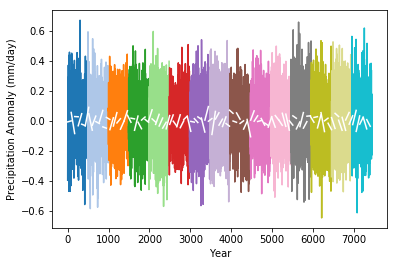

In [9]:
conc_data=DA_tools.concatenate_this(seas_piC,compressed=True)
xax=np.arange(len(conc_data))
cmap=cm.tab20
for i in range(nmod-1):
    
    plt.plot(xax[i*nyears:nyears*(i+1)],conc_data.asma()[i*nyears:nyears*(i+1)],color=cmap(i/float(nmod-1)))
#plot trends
L=86
conc_trunc=conc_data[:int(len(conc_data)/L)*L].asma()
for itrend in range(int(len(conc_data)/L)):
    xn=xax[itrend*L:L*(itrend+1)]
    cn=conc_trunc[itrend*L:L*(itrend+1)]
    p=np.polyfit(xn,cn,1)
    plt.plot(xn,np.polyval(p,xn),"w")
plt.xlabel("Year")
plt.ylabel("Precipitation Anomaly (mm/day)")
#plt.savefig("/home/kdm2144/NCA4Drought/FIGURES/EXPLANATORY/piControl.png")

ssp126 1.2352901181614744
ssp245 2.3753768817416714
missing data for HadGEM3-GC31-LL pr ssp370
ssp370 3.849320530100603
ssp585 4.614769260329453


Text(0, 0.5, 'Normalized Frequency')

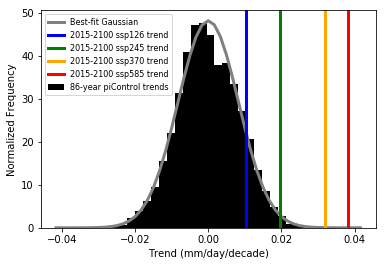

In [11]:
slopes=bootstrap_slopes(conc_data,L).asma()
tmp=plt.hist(slopes,25,density=True,label="86-year piControl trends",color="k")
DA_tools.fit_normals_to_data(slopes,c=cm.gray(.5),lw=3,label="Best-fit Gaussian")
for ssplabel in ["ssp126","ssp245","ssp370","ssp585"]:
    test=X.ensemble_average(ssplabel)
    test.getAxis(1).id="time"
    ssp=cmip5.get_linear_trends(MV.average(getattr(cdutil,season)(test),axis=0))
    print(ssplabel,ssp/np.std(slopes))
    plt.axvline(float(ssp),c=colorscenario(ssplabel),lw=3,label="2015-2100 "+ssplabel+" trend")
plt.legend(loc=0,fontsize=8)
plt.xlabel("Trend (mm/day/decade)")
plt.ylabel("Normalized Frequency")
#plt.savefig("/home/kdm2144/NCA4Drought/FIGURES/EXPLANATORY/SN_scenario.png")

In [13]:
stats.norm.interval(.99)

(-2.5758293035489004, 2.5758293035489004)